# Лабораторная работа 7

In [ ]:
import pandas as pd

data = pd.read_csv('car.data', header=None)

columns = ['buying', 'maint', 'doors', 'persons', 'lug_boot', 'safety', 'class']
data.columns = columns

data


,buying,maint,doors,persons,lug_boot,safety,class
0,vhigh,vhigh,2,2,small,low,unacc
1,vhigh,vhigh,2,2,small,med,unacc
2,vhigh,vhigh,2,2,small,high,unacc
3,vhigh,vhigh,2,2,med,low,unacc
4,vhigh,vhigh,2,2,med,med,unacc
...,...,...,...,...,...,...,...
1723,low,low,5more,more,med,med,good
1724,low,low,5more,more,med,high,vgood
1725,low,low,5more,more,big,low,unacc
1726,low,low,5more,more,big,med,good


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1728 entries, 0 to 1727
Data columns (total 7 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   buying    1728 non-null   object
 1   maint     1728 non-null   object
 2   doors     1728 non-null   object
 3   persons   1728 non-null   object
 4   lug_boot  1728 non-null   object
 5   safety    1728 non-null   object
 6   class     1728 non-null   object
dtypes: object(7)
memory usage: 94.6+ KB
None
       buying  maint doors persons lug_boot safety  class
count    1728   1728  1728    1728     1728   1728   1728
unique      4      4     4       3        3      3      4
top     vhigh  vhigh     2       2    small    low  unacc
freq      432    432   432     576      576    576   1210
buying      0
maint       0
doors       0
persons     0
lug_boot    0
safety      0
class       0
dtype: int64


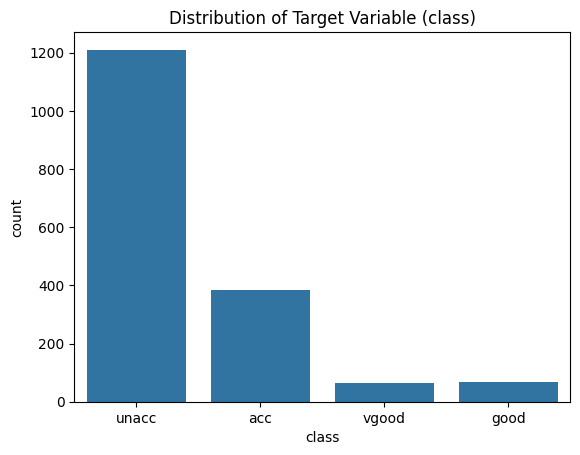

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

print(data.info())
print(data.describe())
print(data.isnull().sum())

sns.countplot(x='class', data=data)
plt.title('Distribution of Target Variable (class)')
plt.show()

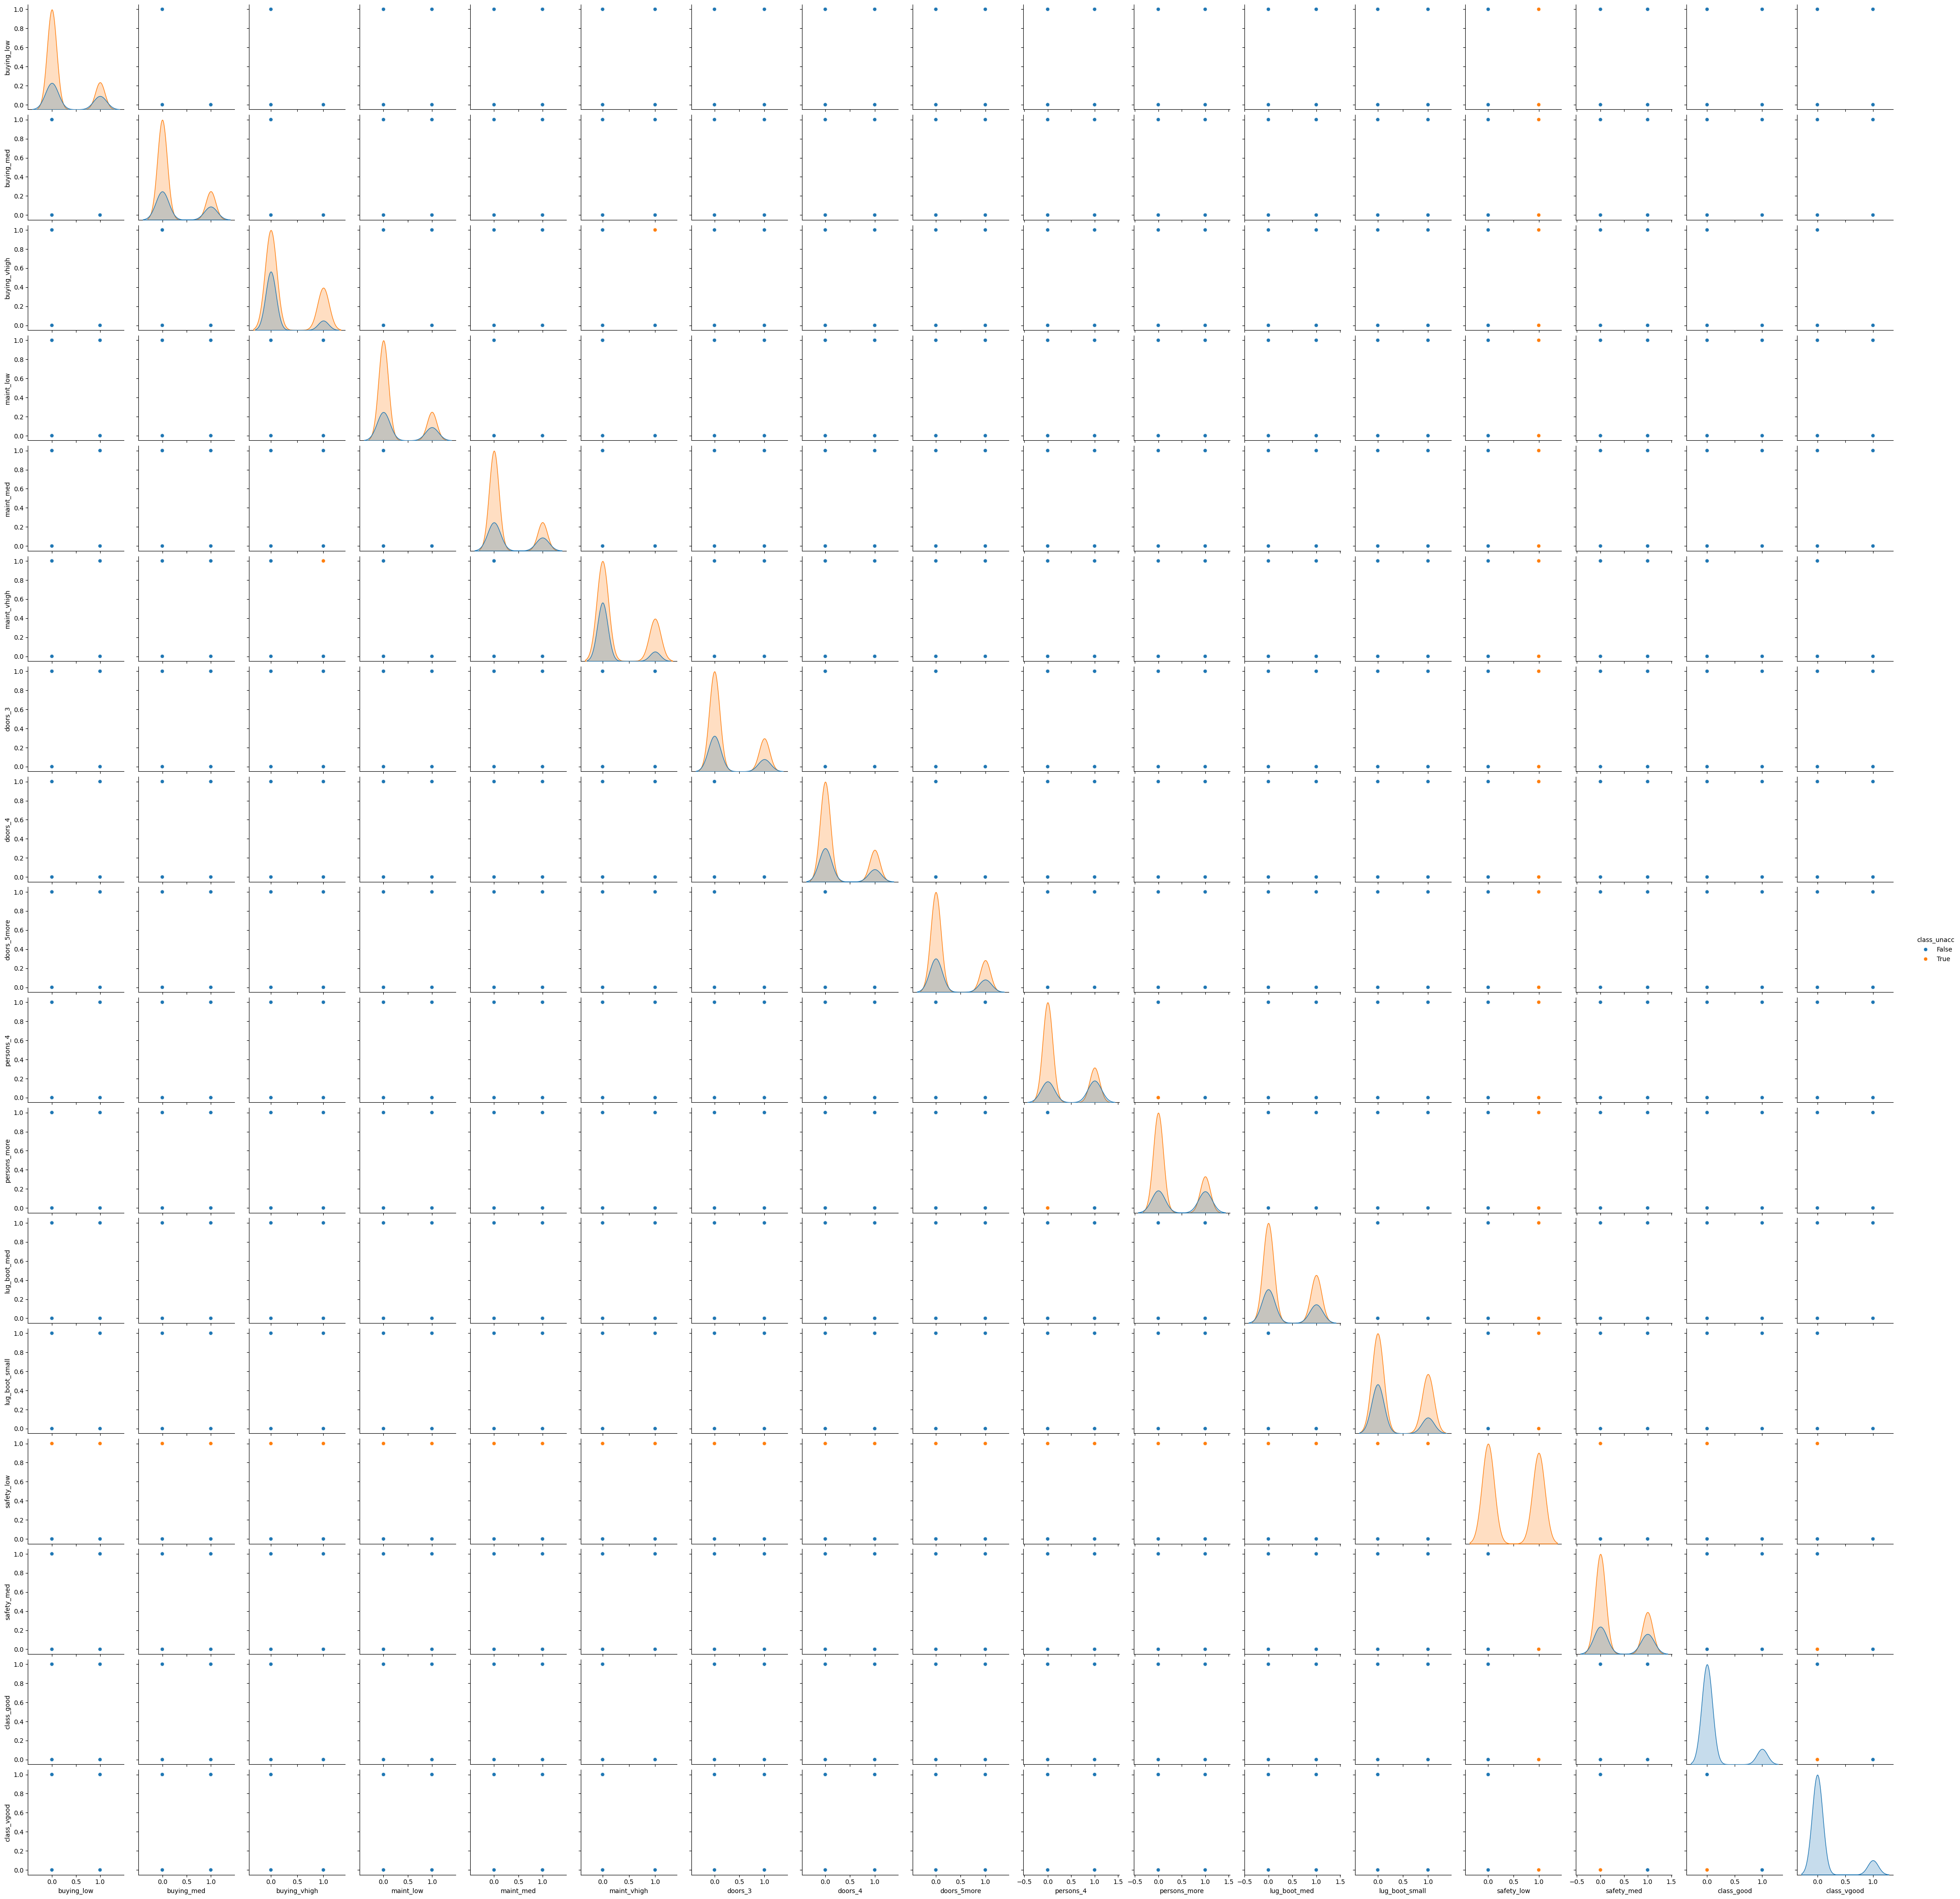

In [ ]:
data_encoded = pd.get_dummies(data, drop_first=True)

sns.pairplot(data_encoded, hue="class_unacc")
plt.show()

for col in data_encoded.columns:
    if data_encoded[col].dtype == 'uint8':
        sns.countplot(x=col, data=data_encoded)
        plt.title(f'Distribution of {col}')
        plt.show()

In [ ]:
from sklearn.model_selection import train_test_split

X = data_encoded.drop('class_unacc', axis=1)
y = data_encoded['class_unacc']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

print(f"Train shape: {X_train.shape}")
print(f"Test shape: {X_test.shape}")


Train shape: (1209, 17)
Test shape: (519, 17)


In [ ]:
import xgboost as xgb
from sklearn.metrics import f1_score

model = xgb.XGBClassifier(use_label_encoder=False, eval_metric='logloss')
model.fit(X_train, y_train)

y_pred = model.predict(X_test)

f1 = f1_score(y_test, y_pred)
print(f"F1 Score: {f1}")


F1 Score: 0.9972067039106145


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [22:33:41] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


In [ ]:
!pip install optuna

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 364.4/364.4 kB 9.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 233.5/233.5 kB 12.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 78.6/78.6 kB 4.9 MB/s eta 0:00:00


In [ ]:
import optuna
from optuna import Trial

def objective(trial: Trial):
    max_depth = trial.suggest_int('max_depth', 3, 10)
    eta = trial.suggest_loguniform('eta', 1e-3, 1e-1)
    gamma = trial.suggest_loguniform('gamma', 1e-3, 1e-1)

    model = xgb.XGBClassifier(
        max_depth=max_depth,
        eta=eta,
        gamma=gamma,
        use_label_encoder=False,
        eval_metric='logloss'
    )

    model.fit(X_train, y_train)

    y_pred = model.predict(X_test)

    f1 = f1_score(y_test, y_pred)

    return f1

study = optuna.create_study(direction='maximize')

study.optimize(objective, n_trials=50)

print(f"Best parameters: {study.best_params}")
print(f"Best F1 score: {study.best_value}")


[I 2024-12-21 22:35:08,347] A new study created in memory with name: no-name-5e2add72-fd4a-4e56-b300-92378f25401d
<ipython-input-14-e13855ebcf56>:6: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  eta = trial.suggest_loguniform('eta', 1e-3, 1e-1)
<ipython-input-14-e13855ebcf56>:7: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  gamma = trial.suggest_loguniform('gamma', 1e-3, 1e-1)
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [22:35:08] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
[I 2024-12-21 22:35:08,466] Trial 0 finished with value: 0.8164196123147093 and parame

Best parameters: {'max_depth': 9, 'eta': 0.09672657339530301, 'gamma': 0.0010322092127822732}
Best F1 score: 0.9958041958041958


Best parameters:   
{'max_depth': 9, 'eta': 0.09672657339530301, 'gamma': 0.0010322092127822732}
  
Best F1 score:  
0.9958041958041958